This notebook focuses on the EDA and visualization of the data. The goal of this competition is to compute location (latDeg and lngDeg) down to decimeter or even centimeter resolution, if possible for each test phone and time. So, our target variables are latDeg and longDeg.

## Contents
* [Overview of the data](#1)
* [Let's explore the data a bit](#2)
   * [Reading GNSS logs](#2-1)
* [Visualizing the tracks](#3)



<a id="1"></a>
# OVERVIEW OF THE DATA

Let's first understand how data is structured. 
There are 3 main folders 
1. Metadata
2. test
3. train 

and 3 files
1. baseline_locations_test.csv- contains the coordinates estimated using a simple approach
2. baseline_locations_train.csv
3. sample_submission.csv

Let's first look at the test and train folders. 
* Both these folders contain sub-folders. These subfolders have been named according to the following format-"YYYY-MM-DD-{Country code in 2 letters}-{Region}-{Collection index}". For eg. 2020-05-14-US-MTV-1. The phones were mounted on the dashboard, while the "ground truth" gps location was collected by a much larger gps antenna in the back seat.



In [ ]:
!ls ../input/google-smartphone-decimeter-challenge/train

In [ ]:
!ls ../input/google-smartphone-decimeter-challenge/test

* Each of these subfolders contain a few subfolders which have the name of a phone which was used for getting the measurements. 

In [ ]:
!ls ../input/google-smartphone-decimeter-challenge/train/2020-05-14-US-MTV-1

* Each of the phone subfolders contain a sub-folder "supplemental" and 3 files in case of train folder and 2 in case of test folder.

In [ ]:
!ls ../input/google-smartphone-decimeter-challenge/train/2020-05-14-US-MTV-1/Pixel4

* The file "Phonename_GnssLog.txt" contains the logs or measurements as generated by the GnssLogger App.
* The file "Phonename_derived.csv" contains GNSS intermediate values derived from raw GNSS measurements, provided for convenience.
* the file "groundtruth.csv" contains reference locations at expected timestamps, i.e. the actual locations at the given timestamps.
* The sub-folder "supplemental" contains .20o/.21o and .nmea files whic contain equivalent data to the GNSS logs in other formats used by the GPS community. Since .nmea file is equivalent to the groundtruth it's not present in the test set.

In [ ]:
!ls ../input/google-smartphone-decimeter-challenge/train/2020-05-14-US-MTV-1/Pixel4/supplemental

* Metadata contains 3 files:- all three files are used as mappings for the various variables in the GNSS measurements.

In [ ]:
!ls ../input/google-smartphone-decimeter-challenge/metadata

In the NMEA file, each location is described jointly by a pair of GGA and RMC sentences, as depicted in the figure given below
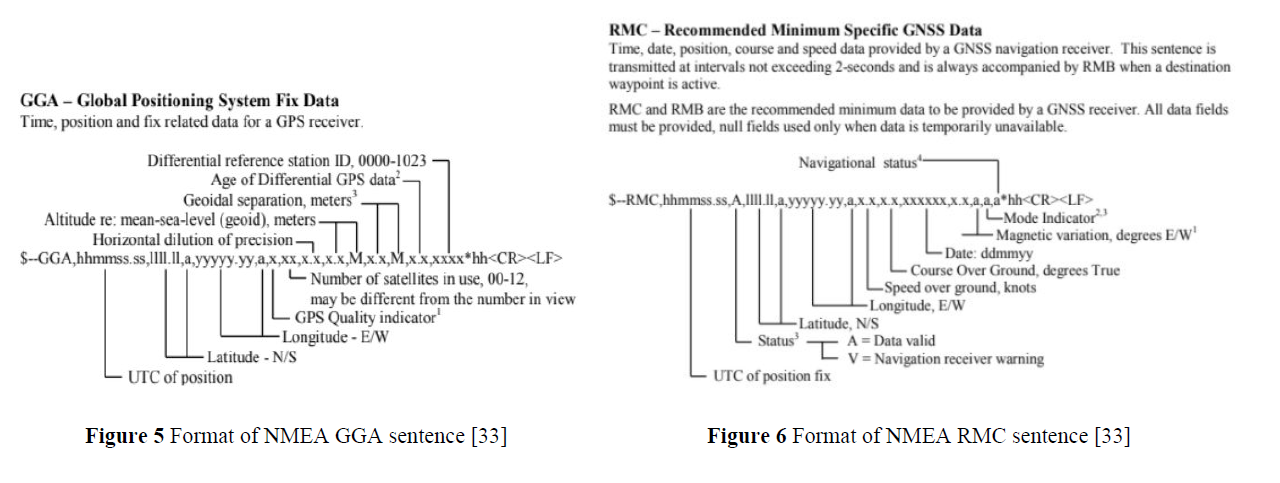

<a id="2"></a>
# Let's explore the data a bit!

In [ ]:
!pip install pynmea2
import glob
import itertools
import json
import os
import warnings
warnings.filterwarnings('ignore')

import geopandas as gpd
from geopandas import GeoDataFrame
import geoplot as gplt
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd
import plotly.express as px
import pynmea2
import requests
import seaborn
from shapely.geometry import Point, shape
import shapely.wkt

%matplotlib inline

In [ ]:
train_file=pd.read_csv('../input/google-smartphone-decimeter-challenge/baseline_locations_train.csv')
train_file.head()

In [ ]:
test_file=pd.read_csv('../input/google-smartphone-decimeter-challenge/baseline_locations_test.csv')
test_file.head()

In [ ]:
print(f'Number of unique phone names in training data: {train_file["phoneName"].nunique()}')
print(f'Number of unique phone names in test data: {test_file["phoneName"].nunique()}')
print(f'Number of unique collections in training data: {train_file["collectionName"].nunique()}')
print(f'Number of unique collections in test data: {test_file["collectionName"].nunique()}')
print(f'Number of unique phones in training data: {train_file["phone"].nunique()}')
print(f'Number of unique phones in test data: {test_file["phone"].nunique()}')

In [ ]:
train_file["phone"].value_counts()

In [ ]:
test_file["phone"].value_counts()

All the phones have enough data and especially in the test set.

In [ ]:
train_file.info()

There are no missing values,lattitude and longitude are float values.Also,from the data description, millisSinceGpsEpoch is "an integer number of milliseconds since the GPS epoch (1980/1/6 midnight UTC)

In [ ]:
sample_submission=pd.read_csv('../input/google-smartphone-decimeter-challenge/sample_submission.csv')
sample_submission.head()

In [ ]:
derived=pd.read_csv('../input/google-smartphone-decimeter-challenge/train/2020-05-14-US-MTV-1/Pixel4/Pixel4_derived.csv')
derived.head()

In [ ]:
derived.info()

There are no null values and the constellationType values can be mapped to their actual names through the constellation_type_mapping.csv given in metadata

In [ ]:
ground_truth=pd.read_csv('../input/google-smartphone-decimeter-challenge/train/2020-05-14-US-MTV-1/Pixel4/ground_truth.csv')
ground_truth.head()

In [ ]:
ground_truth.info()

There are no null values 

<a id="2-1"></a>
**Reading GNSS logs**

In [ ]:
# from https://www.kaggle.com/sohier/loading-gnss-logs
def gnss_log_to_dataframes(path):
    print('Loading ' + path, flush=True)
    gnss_section_names = {'Raw','UncalAccel', 'UncalGyro', 'UncalMag', 'Fix', 'Status', 'OrientationDeg'}
    with open(path) as f_open:
        datalines = f_open.readlines()

    datas = {k: [] for k in gnss_section_names}
    gnss_map = {k: [] for k in gnss_section_names}
    for dataline in datalines:
        is_header = dataline.startswith('#')
        dataline = dataline.strip('#').strip().split(',')
        # skip over notes, version numbers, etc
        if is_header and dataline[0] in gnss_section_names:
            gnss_map[dataline[0]] = dataline[1:]
        elif not is_header:
            datas[dataline[0]].append(dataline[1:])

    results = dict()
    for k, v in datas.items():
        results[k] = pd.DataFrame(v, columns=gnss_map[k])
    # pandas doesn't properly infer types from these lists by default
    for k, df in results.items():
        for col in df.columns:
            if col == 'CodeType':
                continue
            results[k][col] = pd.to_numeric(results[k][col])

    return results

In [ ]:
gnss=gnss_log_to_dataframes('../input/google-smartphone-decimeter-challenge/train/2020-05-14-US-MTV-1/Pixel4/Pixel4_GnssLog.txt')
print(gnss.keys())

GNSS logs contain 5 types of messages.

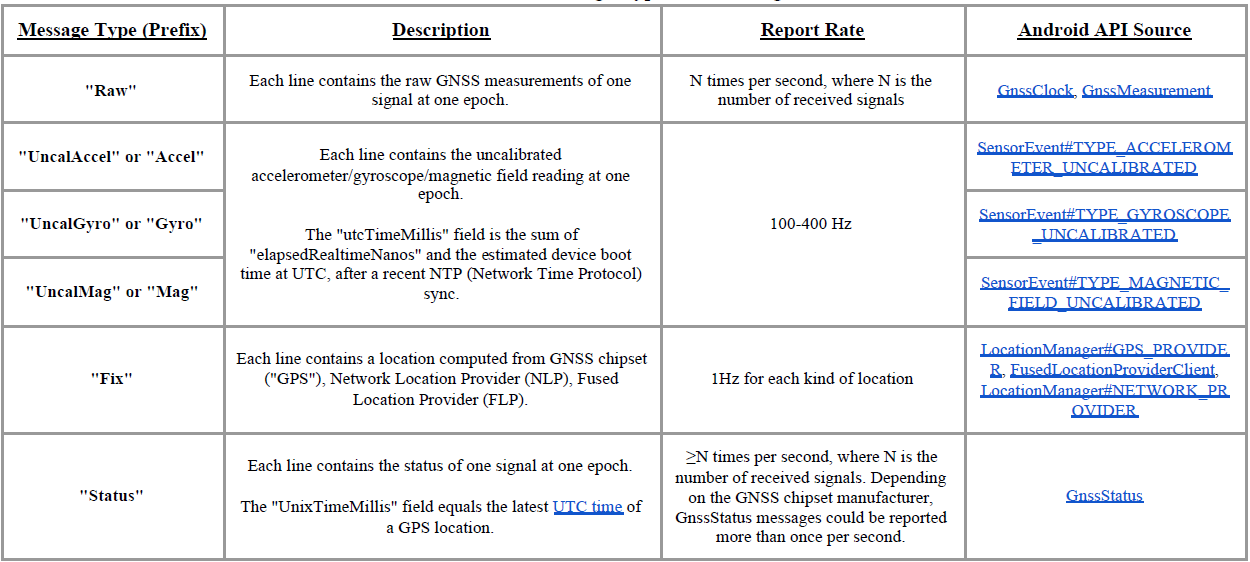

<a href ="https://www.kaggle.com/google/android-smartphones-high-accuracy-datasets?select=ION+GNSS+2020+Android+Raw+GNSS+Measurement+Datasets+for+Precise+Positioning.pdf" title = "Message types in GNSSLog" style = "font-size:20px,color: dimgrey, text-align:left,font-family:serif">Image Source: Message types in GNSSLog </a>

In [ ]:
gnss['Raw'].head()

local estimate of GPS time (signal arrival time) =
TimeNanos - (FullBiasNanos + BiasNanos).

Measurements should be discarded if:
* FullBiasNanos is zero or invalid
* Arrival time is negative or unrealistically large
* TimeNanos is empty
* BiasUncertaintyNanos is too large
* State is neither STATE_TOW_DECODED nor STATE_TOW_KNOWN
* ReceivedSvTimeUncertaintyNanos is high
* AccumulatedDeltaRangeState violates this condition:
 * ADR_STATE_VALID == 1 &
 * ADR_STATE_RESET == 0 &
 * ADR_STATE_CYCLE_SLIP == 0
* AccumulatedDeltaRangeUncertaintyMeters is too large


<a id="3"></a>
# VISUALIZING THE TRACKS

In [ ]:
#from https://www.kaggle.com/nayuts/let-s-visualize-dataset-to-understand
def visualize_trafic(df, center, zoom=9):
    fig = px.scatter_mapbox(df,
                            
                            # Here, plotly gets, (x,y) coordinates
                            lat="latDeg",
                            lon="lngDeg",
                            
                            #Here, plotly detects color of series
                            color="phoneName",
                            labels="phoneName",
                            
                            zoom=zoom,
                            center=center,
                            height=600,
                            width=800)
    fig.update_layout(mapbox_style='stamen-terrain')
    fig.update_layout(margin={"r": 0, "t": 0, "l": 0, "b": 0})
    fig.update_layout(title_text="GPS trafic")
    fig.show()

In [ ]:
#Visualizing the baseline locations for the training data
df_sample_trail_gt = pd.read_csv("../input/google-smartphone-decimeter-challenge/baseline_locations_train.csv")
center = {"lat":37.423576, "lon":-122.091232}
visualize_trafic(df_sample_trail_gt, center)

In [ ]:
#Visualizing the baseline locations for the training data
df_sample_trail_test = pd.read_csv("../input/google-smartphone-decimeter-challenge/baseline_locations_test.csv")
center = {"lat":37.423576, "lon":-122.091232}
visualize_trafic(df_sample_trail_test, center)

 As we can see, all the tracks are running along almost the same roads in both training and test data with the exception of a few outliers to the south-east of these paths